<a href="https://colab.research.google.com/github/Tahsin411934/A-real-state-website/blob/main/Cricket_Shot_Classification%7CResNet50%7C96_Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cricket-shot-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2492382%2F4228910%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240906%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240906T142917Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D873833e457ac73809eefaec1996d101e88cf63a5474e969dd9ad1f47ef2d16fa87ce9a612c9be5c395cb010e4caf3f297903baf02b588d3d90f013827f20a8b475a04af067c656fd232671588871d211eac240b3b771dd9f6633119f8cbc772be373e7e1752b8eb443542a8cb23888540d4f162eff4cd0d853aaf75e05bd22342c0ffa428713af2aed7e54217acffa15be5901173cdfc796711b398153e89c4270e87a891ff6f6b05770df13c4f24f9aa433de9f025033fa0cc62de7c09fc8215b08194ce4a97b873f2162c059f70191794f39f29f7ea62f137343d3a0448d1c975022a405355cca71f53665f81997ea48511dddf20f4263d0cbb6ff497e00e4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 676122557 bytes downloaded
Downloaded and uncompressed: cricket-shot-dataset
Data source import complete.


# Importing Libraries

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns



# Custom Dataset Class


In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preparation


In [4]:
data_dir = '/kaggle/input/cricket-shot-dataset/data'
image_paths = []
labels = []
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg', '.webp')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_to_idx[class_name])

train_paths,test_paths, train_labels, test_labels = train_test_split(image_paths,
                                                                     labels, test_size=0.2,
                                                                     stratify=labels,
                                                                     random_state=42)

## Data Transformations


In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

## Dataset and DataLoader

In [6]:
train_dataset = CustomImageDataset(train_paths, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualizing Sample Images


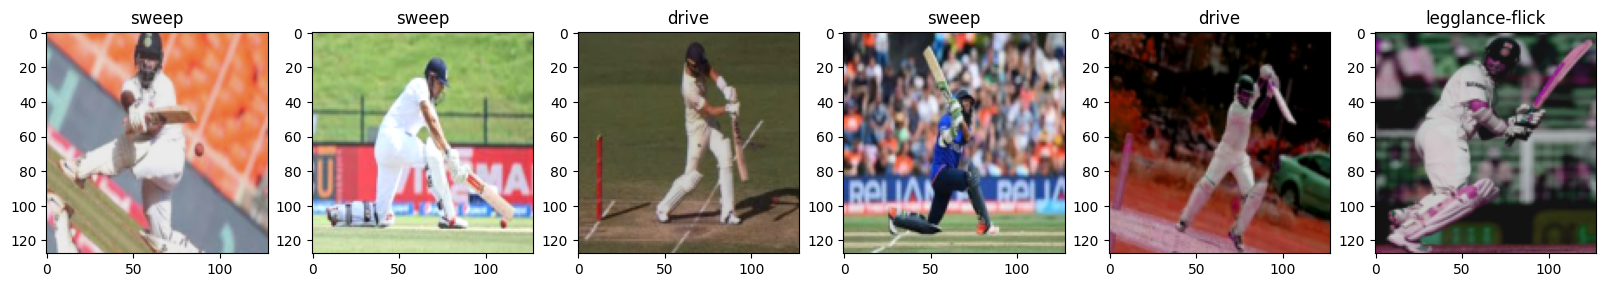

In [7]:
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, label = dataset[i]
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(class_names[label])
    plt.show()

show_images(train_dataset)

# Model Setup

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


# Model Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 0.7423
Epoch 2, Loss: 0.4005
Epoch 3, Loss: 0.2712
Epoch 4, Loss: 0.1955
Epoch 5, Loss: 0.0962
Epoch 6, Loss: 0.1367
Epoch 7, Loss: 0.1437
Epoch 8, Loss: 0.0499
Epoch 9, Loss: 0.1986
Epoch 10, Loss: 0.0765
Epoch 11, Loss: 0.0354
Epoch 12, Loss: 0.0308
Epoch 13, Loss: 0.2473
Epoch 14, Loss: 0.0625
Epoch 15, Loss: 0.1467
Epoch 16, Loss: 0.0251
Epoch 17, Loss: 0.0219
Epoch 18, Loss: 0.0976
Epoch 19, Loss: 0.0522
Epoch 20, Loss: 0.0260


# Model Evaluation

In [10]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")



Accuracy: 0.95


## Confusion Matrix

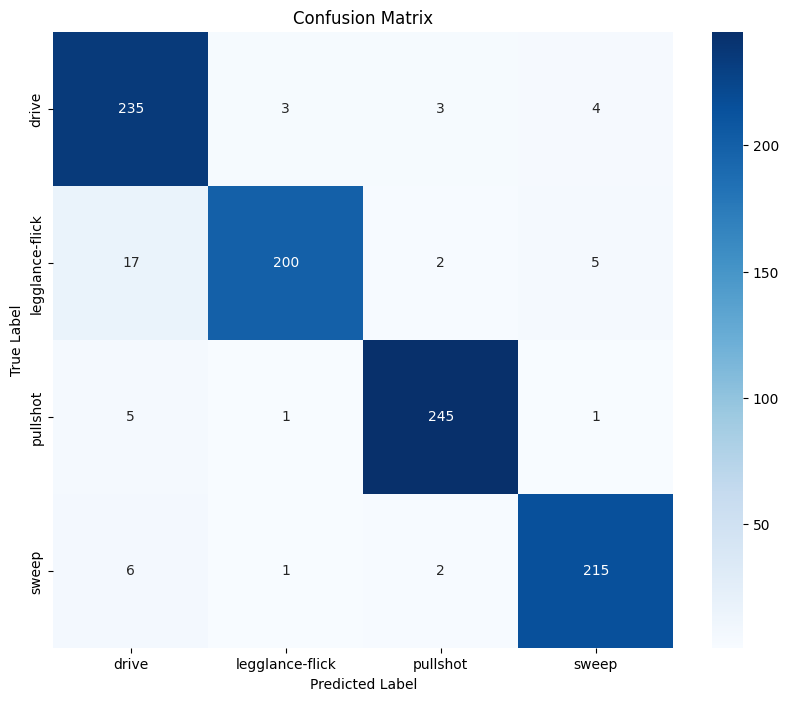

In [11]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
cm = confusion_matrix(all_labels, all_preds)
class_names = ['drive', 'legglance-flick', 'pullshot', 'sweep']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predictions

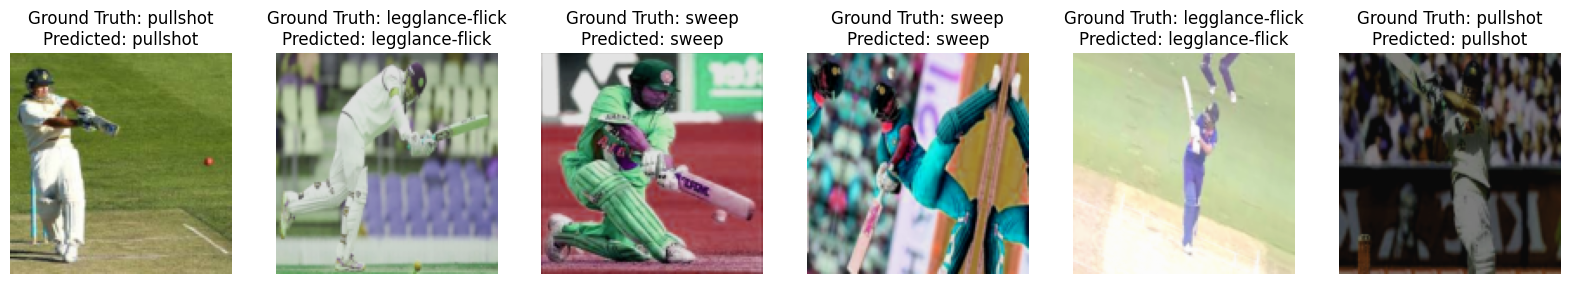

In [12]:
def show_predictions(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))
    for i in range(num_images):
        image, true_label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image)
            _, pred_label = torch.max(output, 1)
        pred_label = pred_label.item()

        ax = axes[i]
        ax.imshow(image.squeeze().permute(1, 2, 0).cpu())
        ax.set_title(f"Ground Truth: {class_names[true_label]}\nPredicted: {class_names[pred_label]}")
        ax.axis('off')
    plt.show()

show_predictions(test_dataset)